In [2]:
using Pkg
Pkg.activate("../tambo/")
using Tambo
using JLD2
using StatsBase
using Plots
using StaticArrays
using Glob 

  Activating project at `~/Documents/physics/TAMBO/tambo`


In [3]:
TAMBO_PATH = "../Tambo"
# This should be the simulation parameters jld2 file

#path to sim file
SIMULATION_FILE = "../resources/Larger_Valley/sim_files/larger_valley_00000_00003.jld2"

"../resources/Larger_Valley/sim_files/larger_valley_00000_00003.jld2"

In [234]:
sim = jldopen(SIMULATION_FILE)
config = SimulationConfig(; geo_spline_path="../resources/tambo_spline.jld2", filter(x->x[1]!=:geo_spline_path, sim["config"])...)
geo = Tambo.Geometry(config)
injector = Tambo.Injector(config)
plane = Tambo.Plane(config.plane_orientation, config.tambo_coordinates,geo)
size = SVector{3}([2,2,0.03])*units.m
altmin = 2300units.m
altmax = 3700units.m
modules = Tambo.make_detector_array(
    5000units.m,
    150units.m,
    altmin,
    altmax,
    plane,
    geo,
    size,
)
nmodules = length(modules)
#config.plane_orientation, propagator.config.tambo_coordinates

702

In [237]:
#path to files 
file_names = ["retest_normal*jld2","retest_small*jld2","retest_medium*jld2"]
other_file_name = ["larger*jld2"]


files = glob(file_names[2],"/Users/pavelzhelnin/Documents/physics/TAMBO/resources/airshowers/big_showers/triggered_showers")


20-element Vector{String}:
 "/Users/pavelzhelnin/Documents/p" ⋯ 93 bytes ⋯ "000_00001_triggered_events.jld2"
 "/Users/pavelzhelnin/Documents/p" ⋯ 93 bytes ⋯ "000_00002_triggered_events.jld2"
 "/Users/pavelzhelnin/Documents/p" ⋯ 93 bytes ⋯ "000_00003_triggered_events.jld2"
 "/Users/pavelzhelnin/Documents/p" ⋯ 93 bytes ⋯ "000_00004_triggered_events.jld2"
 "/Users/pavelzhelnin/Documents/p" ⋯ 93 bytes ⋯ "000_00005_triggered_events.jld2"
 "/Users/pavelzhelnin/Documents/p" ⋯ 93 bytes ⋯ "000_00006_triggered_events.jld2"
 "/Users/pavelzhelnin/Documents/p" ⋯ 93 bytes ⋯ "000_00007_triggered_events.jld2"
 "/Users/pavelzhelnin/Documents/p" ⋯ 93 bytes ⋯ "000_00008_triggered_events.jld2"
 "/Users/pavelzhelnin/Documents/p" ⋯ 93 bytes ⋯ "000_00009_triggered_events.jld2"
 "/Users/pavelzhelnin/Documents/p" ⋯ 93 bytes ⋯ "000_00010_triggered_events.jld2"
 "/Users/pavelzhelnin/Documents/p" ⋯ 93 bytes ⋯ "000_00011_triggered_events.jld2"
 "/Users/pavelzhelnin/Documents/p" ⋯ 93 bytes ⋯ "000_00012_triggered_ev

In [6]:
function calc_triggered_event_rate(triggered_events)
    γ = 2.52
    norm = 1.8e-18 / units.GeV / units.cm^2 / units.second * (1 /(100units.TeV))^-γ
    pl = Tambo.PowerLaw(γ, 100units.GeV, 1e9units.GeV, norm)
    fluxes = pl.(triggered_events["initial_state"]["energy"])
    wgts = oneweight.(triggered_events, Ref(injector), Ref(injector.xs)) ./ (length(files)*config.n) # FIXME hack
    #wgts = oneweight.(triggered_events, Ref(injector), Ref(injector.xs)) ./ 20000
    global_fit_rates = fluxes .* wgts
    return global_fit_rates
end

calc_triggered_event_rate (generic function with 1 method)

In [371]:
function cosmo_triggered_event_rate(triggered_events)
    γ = 1
    #norm = 2e-23 / units.GeV / units.cm^2 / units.second * (1 /(10units.PeV))^-γ
    #rodrigues et al. all AGN  
    norm = 1e-22 / units.GeV / units.cm^2 / units.second * (1 /(4.5units.PeV))^-γ
    pl = Tambo.PowerLaw(γ, 100units.GeV, 1e8units.GeV, norm)

    fluxes = pl.(triggered_events["initial_state"]["energy"])
    wgts = oneweight.(triggered_events, Ref(injector), Ref(injector.xs)) ./ (length(files)*config.n) # FIXME hack
    #wgts = oneweight.(triggered_events, Ref(injector), Ref(injector.xs)) ./ 20000
    global_fit_rates = fluxes .* wgts
    return global_fit_rates
end

cosmo_triggered_event_rate (generic function with 1 method)

In [372]:
function combined_triggered_event_rate(triggered_events)

    return cosmo_triggered_event_rate(triggered_events) + calc_triggered_event_rate(triggered_events)
end

combined_triggered_event_rate (generic function with 1 method)

In [323]:
function diff_sens_calc(triggered_events,energy, γ;normalization=100units.TeV)
    # γ = 2
    norm = 1.0e-18 / units.GeV / units.cm^2 / units.second * (1 /(normalization))^-γ
    pl = Tambo.PowerLaw(γ, 100units.GeV, 1e9units.GeV, norm)
    fluxes = pl.(energy)
    wgts = oneweight.(triggered_events, Ref(injector), Ref(injector.xs)) ./ (length(files)*config.n) # FIXME hack
    #wgts = oneweight.(triggered_events, Ref(injector), Ref(injector.xs)) ./ 20000
    global_fit_rates = fluxes .* wgts
    return global_fit_rates
end

diff_sens_calc (generic function with 1 method)

In [8]:
function load_events(files)
    all_events = Vector{Tambo.InjectionEvent}()
    #det config has to be configured 
    for file in files
        triggered_events = load(file)["5000.0_150.0"]
        append!(all_events, triggered_events)
    end
    return all_events 
end 

load_events (generic function with 1 method)

In [313]:
all_rates = calc_triggered_event_rate(load_events(files))

events_per_3years_5kdetectors = sum(all_rates) * 1 * (5000/nmodules) * 3 * 10^7.5 * units.second

display("New Valley Location: $(events_per_3years_5kdetectors)")

"New Valley Location: 1.436053545344788"

In [373]:
cosmo_files = load_events(files)
cosmo_files = cosmo_files[cosmo_files["initial_state"]["energy"].<1e8units.GeV]
cosmo_all_rates = combined_triggered_event_rate(cosmo_files)

events_per_3years_5kdetectors = sum(cosmo_all_rates) * 1 * (5000/nmodules) * 3 * 10^7.5 * units.second

display("New Valley Location: $(events_per_3years_5kdetectors)")

"New Valley Location: 6.914389927080509"

Differential Sensitivity Calculation for 10 years and 22k detectors

In [ ]:
sizes_test = ["1.8 x 0.8m", "2 x 2m", "4 x 4m"]
anim = @animate for (idx,file) in enumerate(file_names)
    files = glob(file,"/Users/pavelzhelnin/Documents/physics/TAMBO/resources/airshowers/big_showers/triggered_showers")
    all_events = load_events(files)
    all_rates = calc_triggered_event_rate(all_events)

    events_per_3years_5kdetectors = sum(all_rates) * 1 * (5000/nmodules) * 3 * 10^7.5 * units.second

    println("New Valley Location: $(events_per_3years_5kdetectors)")

    azimuths = [rad2deg(all_events["final_state"]["direction"][i].ϕ) for i in 1:length(all_events["final_state"]["direction"])]
    zeniths = [rad2deg(all_events["final_state"]["direction"][i].θ) for i in 1:length(all_events["final_state"]["direction"])]
    size = sizes_test[idx]
    histogram2d(azimuths,zeniths,xlabel="Azimuth (degrees)",ylabel="Zenith (degrees)",title="$(size) Number of Triggered Showers",
    clims=(0,120),
    bins=10,size=(800,400),ylimit=(60,110), show_empty_bins=true)
end 
gif(anim, "modules_size_acceptance.gif", fps = 1)

In [ ]:
sizes_test = ["1.8 x 0.8m", "2 x 2m", "4 x 4m"]
animated = @animate for (idx,file) in enumerate(file_names)

    files = glob(file,"/Users/pavelzhelnin/Documents/physics/TAMBO/resources/airshowers/big_showers/triggered_showers")
    all_events = load_events(files)

    distances = [] 
    for event in all_events["final_state"]
        distance, point, dot = intersect(event.position, event.direction, plane)
        push!(distances, distance)
    end 

    h = fit(Histogram, (all_events["final_state"]["energy"], distances ./units.km),(10 .^ (14:0.5:18), 0:1:20))
    dist_cents = (h.edges[2][1:end-1] .+ h.edges[2][2:end]) / 2
    energy_cents = 10 .^((log10.(h.edges[1][1:end-1]) .+ log10.(h.edges[1][2:end])) / 2)
    size = sizes_test[idx]
    ws = (h.weights./sum(h.weights,dims=2))
    ws[ws.==0].=NaN
    plt = heatmap(energy_cents/units.GeV,dist_cents,ws',
    title="$(size) distances of Triggered Showers", xlabel="energy (GeV)", ylabel="distance (km)",
    xscale=:log10,clim=(0,0.5), show_empty_bins=false)

    
    # histogram2d(all_events["final_state"]["energy"], distances ./units.km, xlabel="final state energy (GeV)",ylabel="distance (km)",title="$(size) distances of Triggered Showers",
    # size=(800,400),label="",xscale=:log10,ylimit=(0,20),clim=(0,200))
    end 
gif(animated, "distances.gif", fps = 1)

In [167]:
simfile = jldopen(simfiles[2])

#tau decay point 
display(simfile["proposal_events"][1].propped_state)
display(simfile["proposal_events"][1].decay_products)

#tau creation 
display(simfile["injected_events"]["final_state"][1])

#tau neutrino insertion 
display(simfile["injected_events"][1])

Particle(pdg_mc=15, energy=273352.28623915365 GeV, position=[1159.7366420245105, 1221.2383778019127, -673.5074146599364]m, direction=(33.6°, 251.0°))

3-element Vector{Tambo.Particle}:
 Particle(pdg_mc=11, energy=182052.6502064968 GeV, position=[1159.7366420245105, 1221.2383778019127, -673.5074146599364]m, direction=(33.6°, 251.0°))
 Particle(pdg_mc=16, energy=57271.13637332889 GeV, position=[1159.7366420245105, 1221.2383778019127, -673.5074146599364]m, direction=(33.6°, 251.0°))
 Particle(pdg_mc=-12, energy=34028.49965932794 GeV, position=[1159.7366420245105, 1221.2383778019127, -673.5074146599364]m, direction=(33.6°, 251.0°))

Particle(pdg_mc=15, energy=273357.6929326749 GeV, position=[1159.8247363366395, 1221.4918145058045, -673.9106661489634]m, direction=(33.6°, 251.0°))

Tambo.InjectionEvent(Particle(pdg_mc=16, energy=282548.5945454805 GeV, position=[3197.202023397268, 7082.780378309728, -10000.00000000031]m, direction=(33.6°, 251.0°)), Particle(pdg_mc=16, energy=477229.6478846782 GeV, position=[3197.202023397268, 7082.780378309728, -10000.0]m, direction=(33.6°, 251.0°)), Particle(pdg_mc=15, energy=273357.6929326749 GeV, position=[1159.8247363366395, 1221.4918145058045, -673.9106661489634]m, direction=(33.6°, 251.0°)), 4.076096918691836e27, 4.076096918691836e27)

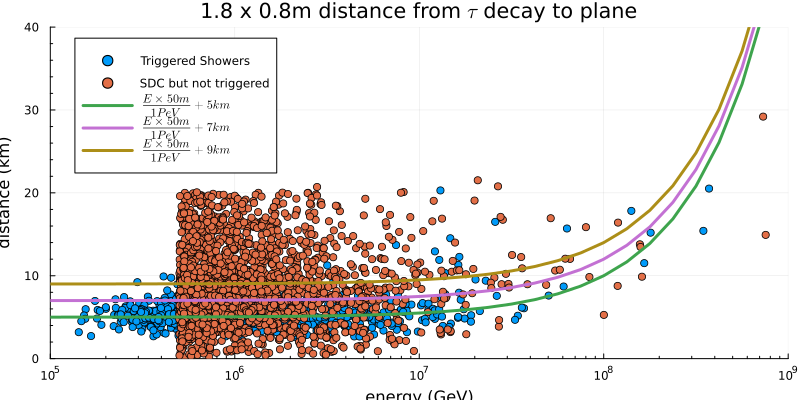

In [235]:
simfiles = glob("larger*jld2","/Users/pavelzhelnin/Documents/physics/TAMBO/resources/Larger_Valley/sim_files")
file = file_names[1]
files = glob(file,"/Users/pavelzhelnin/Documents/physics/TAMBO/resources/airshowers/big_showers/triggered_showers")
triggered_events = Vector{Tambo.InjectionEvent}() 
sdc_events = Vector{Tambo.InjectionEvent}()  
for simpath in simfiles[2:21]
    search_string = split(split(simpath,"_")[end],".")[1]
    simfile = jldopen(simpath)
    triggered_path = files[occursin.(search_string, files)]
    triggered_file = load(triggered_path[1])["5000.0_150.0"]
    append!(triggered_events, triggered_file)
    corsika_indices = unique([i[1] for i in simfile["corsika_indices"]])
    corsika_events = [simfile["injected_events"][corsika_index] for corsika_index in corsika_indices]
    append!(sdc_events, corsika_events)
end 

mask = sdc_events["final_state"]["energy"] .> 5e14
sdc_events = sdc_events[mask]

mask = triggered_events["final_state"]["energy"] .> 5e14
he_triggered_events = triggered_events[mask]
combined = append!(he_triggered_events, sdc_events)
unique_events = Vector{Tambo.InjectionEvent}()  
for v in combined 
    a = 0 
    for j in combined 
        if isequal(v,j)
            a+=1
            continue 
        end 
    end
    if a == 1 
        push!(unique_events,v)
    end
end 

unique_he_distances = [Tambo.intersect(event.position, event.direction, plane)[1] for event in unique_events["final_state"]]
# sdc_distances = [Tambo.intersect(event.position, event.direction, plane)[1] for event in sdc_events["final_state"]]
distances = [Tambo.intersect(event.position, event.direction, plane)[1] for event in triggered_events["final_state"]]
plt = scatter(triggered_events["final_state"]["energy"]./units.GeV, distances ./ units.km, xlabel="energy (GeV)",ylabel="distance (km)",
title="1.8 x 0.8m distance from \$ \\tau \$ decay to plane", legend=:topleft,
xscale=:log10,size=(800,400),xminorticks=true,yminorticks=true,xlimit=(1e5,1e9),ylimit=(0,40),label="Triggered Showers")
# plt1 = scatter(sdc_events["final_state"]["energy"]./units.GeV, sdc_distances ./ units.km, label="",xminorticks=true,yminorticks=true,
# xscale=:log10,xlimit=(1e5,1e9),ylimit=(0,40))
scatter!(plt,unique_events["final_state"]["energy"]./units.GeV, unique_he_distances ./ units.km,xminorticks=true,yminorticks=true,
xscale=:log10,xlimit=(1e5,1e9),ylimit=(0,40),label="SDC but not triggered")

f(x) = ((0.05*x)/1e15) 

# Generate the data points
energies = 10 .^ (14:0.125:18)

y = f.(energies)     # Broadcast the function f over the array x
plot!(plt, energies/units.GeV,y.+5,lw=3,label="\$ \\frac{E \\times 50m}{1PeV} + 5km\$")
plot!(plt, energies/units.GeV,y.+7,lw=3,label="\$ \\frac{E \\times 50m}{1PeV} + 7km\$")
plot!(plt, energies/units.GeV,y.+9,lw=3,label="\$ \\frac{E \\times 50m}{1PeV} + 9km\$")
display(plt)


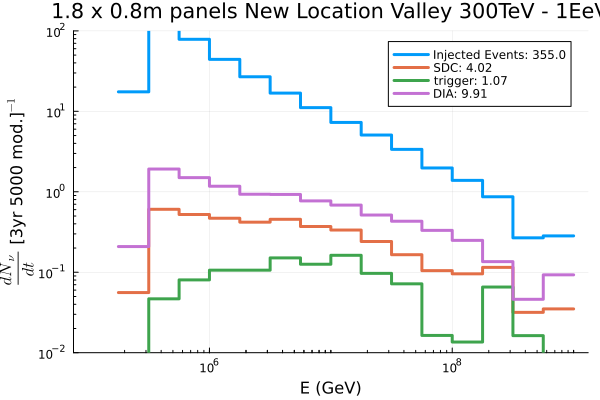

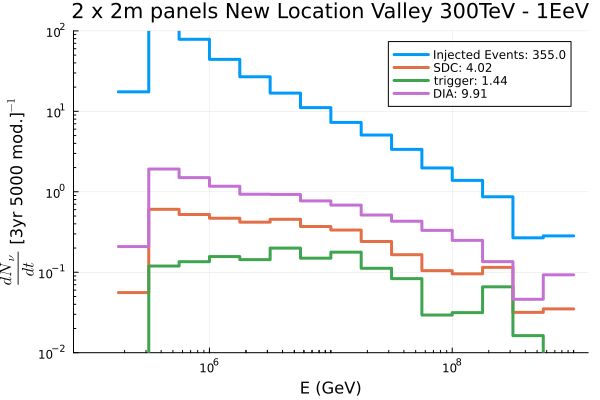

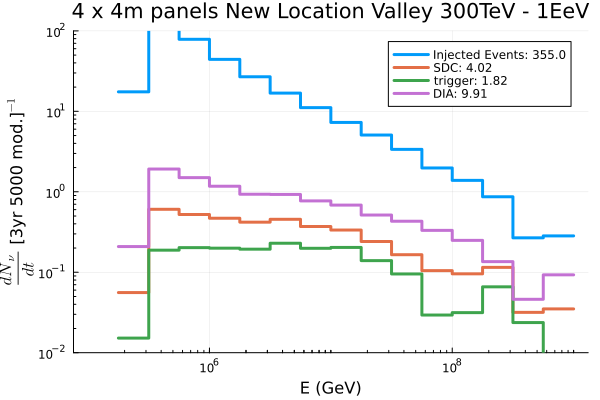

Plots.AnimatedGif("/Users/pavelzhelnin/Documents/physics/TAMBO/notebooks/rate_cuts.gif")
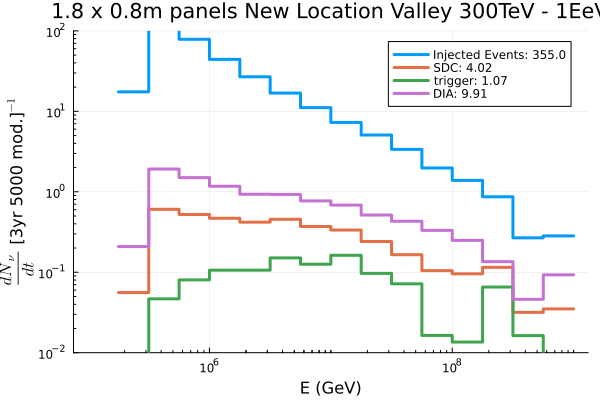

In [120]:
simfiles = glob("larger*jld2","/Users/pavelzhelnin/Documents/physics/TAMBO/resources/Larger_Valley/sim_files")

sizes_test = ["1.8 x 0.8m", "2 x 2m", "4 x 4m"]
animated_rate_cuts = @animate for (idx,file) in enumerate(file_names)
    size = sizes_test[idx]
    files = glob(file,"/Users/pavelzhelnin/Documents/physics/TAMBO/resources/airshowers/big_showers/triggered_showers")

    injected_events = Vector{Tambo.InjectionEvent}() 
    decayinair_events = Vector{Tambo.InjectionEvent}()
    sdc_events = Vector{Tambo.InjectionEvent}()  
    triggered_events = Vector{Tambo.InjectionEvent}() 
    for simpath in simfiles[2:21]
        search_string = split(split(simpath,"_")[end],".")[1]
        simfile = jldopen(simpath)
        triggered_path = files[occursin.(search_string, files)]

        append!(injected_events,simfile["injected_events"])
        mask = [Tambo.check_inside_mtn(event, plane, geo; verbose=false) for event in simfile["proposal_events"]]
        decayinairs = simfile["injected_events"][mask]
        append!(decayinair_events,decayinairs)
        corsika_indices = unique([i[1] for i in simfile["corsika_indices"]])
        corsika_events = [simfile["injected_events"][corsika_index] for corsika_index in corsika_indices]
        append!(sdc_events, corsika_events)

        triggered_file = load(triggered_path[1])["5000.0_150.0"]
        append!(triggered_events, triggered_file)
    end 

    edges = 10 .^ (14:0.25:18)
    cents = 10 .^ ((log10.(edges[1:end-1]) .+ log10.(edges[2:end])) / 2)

    injected_rates = calc_triggered_event_rate(injected_events)
    corsika_rates = calc_triggered_event_rate(sdc_events)
    triggered_rates = calc_triggered_event_rate(triggered_events)
    decayinair_rates = calc_triggered_event_rate(decayinair_events)
    hist_injected_events = fit(Histogram, injected_events["initial_state"]["energy"], Weights(injected_rates), edges)
    hist_corsika_events = fit(Histogram, sdc_events["initial_state"]["energy"], Weights(corsika_rates), edges)
    hist_triggered_events = fit(Histogram, triggered_events["initial_state"]["energy"], Weights(triggered_rates), edges)
    hist_decayinair_events = fit(Histogram, decayinair_events["initial_state"]["energy"], Weights(decayinair_rates), edges)

    inj_5k_rates = round(sum(injected_rates) * 1 * (5000/nmodules) * 3 * 10^7.5 * units.second,sigdigits=3)
    cor_5k_rates = round(sum(corsika_rates) * 1 * (5000/nmodules) * 3 * 10^7.5 * units.second,sigdigits=3)
    trig_5k_rates = round(sum(triggered_rates) * 1 * (5000/nmodules) * 3 * 10^7.5 * units.second,sigdigits=3)
    decay_5k_rates = round(sum(decayinair_rates) * 1 * (5000/nmodules) * 3 * 10^7.5 * units.second,sigdigits=3)

    plt = plot(
        xscale=:log,
        yscale=:log,
        xlabel="E (GeV)",
        xminorticks=true,
        yminorticks=true,
        ylabel="\$ \\frac{dN_{\\nu}}{dt}\$ [3yr 5000 mod.]\$^{-1}\$",
        # # xlimits=(3e5, 1e9),
        ylimits=(1e-2, 1e2),
        # legend=:topright,
        title= "$(size) panels New Location Valley 300TeV - 1EeV",
        size=(600, 400)   
        ) 

    plot!( 
        plt, 
        edges/units.GeV,
        hist_injected_events.weights * (5000/nmodules) * 3 * 10^7.5 * units.second, 
        linetype=:stepbins,
        label="Injected Events: $(inj_5k_rates)",
        lw=3
        )

    plot!( 
        plt, 
        edges/units.GeV,
        hist_corsika_events.weights * (5000/nmodules) * 3 * 10^7.5 * units.second, 
        linetype=:stepbins,
        label="SDC: $(cor_5k_rates)",
        lw=3
        )

    plot!( 
        plt, 
        edges/units.GeV,
        hist_triggered_events.weights * (5000/nmodules) * 3 * 10^7.5 * units.second, 
        linetype=:stepbins,
        label="trigger: $(trig_5k_rates)",
        lw=3
        )

    plot!(
        plt, 
        edges/units.GeV,
        hist_decayinair_events.weights * (5000/nmodules) * 3 * 10^7.5 * units.second,
        linetype=:stepbins,
        label="DIA: $(decay_5k_rates)",
        lw=3
    )

        
# plot!(
#     plt,
#     edges / units.GeV,
#     #hist_injected_events.weights * (5000/nmodules) * 3 * 10^7.5 * units.second *20,
#     hist_three.weights .*norm_factors,
#     linetype=:stepbins,
#     label="",
#     lw=3
#     )
display(plt)
end  
gif(animated_rate_cuts, "rate_cuts.gif", fps = 1)
#histogram(simfile["injected_events"]["initial_state"]["energy"],weights = injected_rates,xscale=:log10)


#     for events in› jldopen(simfile)
#         println(events["final_state"]["energy"])
#         break 
#     end
#     break 
# end



In [305]:
edges = 10 .^ (13:1:18)
cents = 10 .^ ((log10.(edges[1:end-1]) .+ log10.(edges[2:end])) / 2)
norm_factors = []

for (idx,edge) in enumerate(edges[1:end-1])
    # println("edge: ", edge)
    binned_events = filter(x-> x.initial_state.energy .> edges[idx] && x.initial_state.energy .< edges[idx+1], all_events)
    # println(length(binned_events))
    if length(binned_events) == 0
        continue
    end
    energies = [binned_events[i].initial_state.energy for i in 1:length(binned_events)]
    rates = diff_sens_calc(binned_events, energies, 1)
    norm_factor = 1 /  sum(rates * 1 * (22000/nmodules) * 10 * 10^7.5 * units.second)
    # println("norm_factors: ", norm_factor)
    push!(norm_factors,norm_factor)
    # println("rate: ", norm_factor * sum(rates * 1 * (22000/nmodules) * 10 * 10^7.5 * units.second))
    # println("rate: ", norm_factor * 1e-18)
end

diff_sens = 1e-18 .* norm_factors


plt = plot(
    xscale=:log,
    # yscale=:log,
    xlabel="\$E (GeV)\$",
    xminorticks=true,
    yminorticks=true,
    ylabel="\$ \\nu_{\\tau}\$ \$E^{2}\\Phi [GeV cm^{-2} s^{-1} sr^{-1}]\$",
    xlimits=(1e5, 1e9),
    title="TAMBO differential sensitivity",
    #ylimits=(1e-20, 1e-8),
    legend=:topleft,
    size=(600, 400)   
)

edges = 10 .^ (14:1:18)
cents = 10 .^ ((log10.(edges[1:end-1]) .+ log10.(edges[2:end])) / 2)
#hist_three = fit(Histogram, unique(all_events["initial_state"]["energy"]), Weights((all_events["initial_state"]["energy"]).^2 .* (1.8e-18)), edges)

plot!(
    plt,
    edges / units.GeV,
    log.(10, (cents / units.GeV) .^ 2 .* diff_sens),
    # hist_three.weights .*norm_factors,
    linetype=:stepbins,
    label="",
    lw=3
    )

#display(plt)
savefig(plt,"TAMBO_diff_sens.pdf")

"/Users/pavelzhelnin/Documents/physics/TAMBO/notebooks/TAMBO_diff_sens.pdf"

Effective Area Calculation 

In [300]:
plt = plot(
    xscale=:log,
    yscale=:log,
    xlabel="\$ E (GeV) \$",
    xminorticks=true,
    yminorticks=true,
    ylabel="\$ A\\Phi (m^{2}sr) \$",
    xlimits=(1e5, 1e8),
    ylimits=(1e1, 1e6),
    legend=:topleft,
    size=(600, 400)   
)

γ = 2.5
norm = 2.3e-18 / units.GeV / units.cm^2 / units.second * (1 /(100units.TeV))^-γ
pl = Tambo.PowerLaw(γ, 100units.GeV, 1e9units.GeV, norm)
fluxes = pl.(unique(all_events["initial_state"]["energy"]))
edges = 10 .^ (14:0.25:18)
cents = (edges[1:end-1] .+ edges[2:end]) / 2
wgts = oneweight.(all_events, Ref(injector), Ref(injector.xs)) ./ (config.n * length(files))

label = "Triggered Effective Areas"
hist_three = fit(Histogram, unique(all_events["initial_state"]["energy"]), Weights(wgts), edges)

plot!(
    plt,
    cents / units.GeV,
    hist_three.weights ./ diff(edges) ./units.m^2 * (22000/nmodules),
    linetype=:stepmid,
    label="",
    title="TAMBO geometrical acceptance 22k modules \n 2x2m modules",
    lw=3
    )


f(x) = 300 * (x/1e15)^1.5

# Generate the data points
y = f.(cents)     # Broadcast the function f over the array x
plot!(plt, cents/units.GeV,y,lw=3,label="\$ 300 \\times \\left( \\frac{E}{1 PeV} \\right)^{1.5} m^{2}sr\$")


f(x) = 160 * (x/1e15)^0.4
# Generate the data points

ic_edges = 10 .^ (14.75:0.25:16.25)
ic_cents = (ic_edges[1:end-1] .+ ic_edges[2:end]) / 2

icecube = f.(ic_cents)     # Broadcast the function f over the array x
plot!(plt, ic_cents/units.GeV,icecube,lw=3,label="IceCube \$ \\nu_\\tau \$")

#display(plt)
savefig(plt, "TAMBOacceptance_22k_with_IC.pdf")

"/Users/pavelzhelnin/Documents/physics/TAMBO/notebooks/TAMBOacceptance_22k_with_IC.pdf"

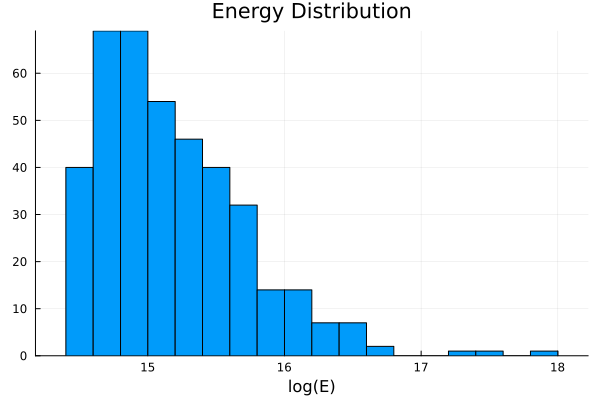

In [51]:
histogram(log10.(all_events["initial_state"]["energy"]),xlabel="log(E)",label="",title="Energy Distribution")

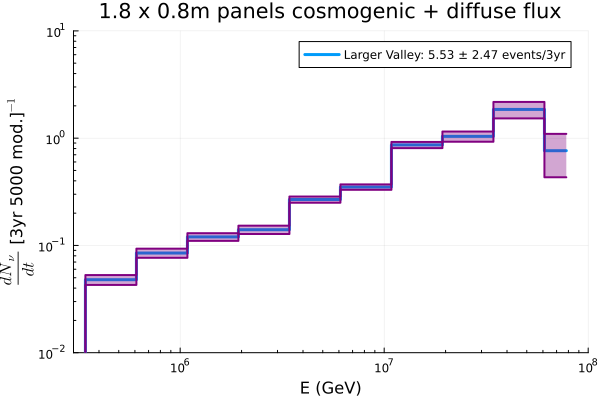

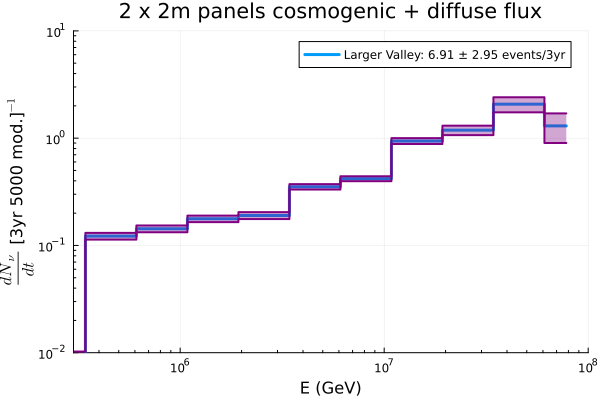

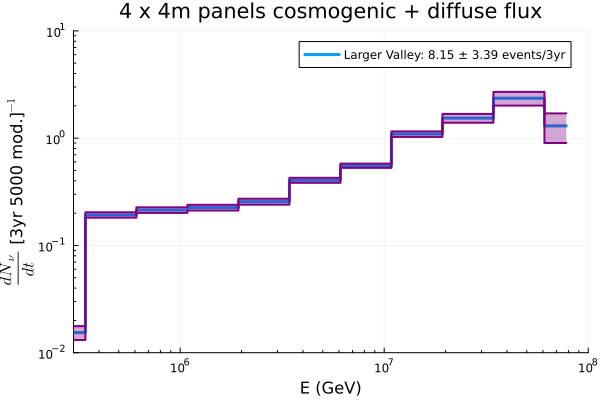

Plots.AnimatedGif("/Users/pavelzhelnin/Documents/physics/TAMBO/notebooks/anim_fps15.gif")
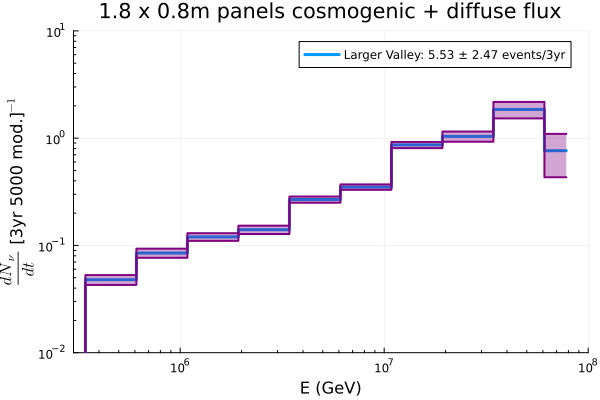

In [374]:
file_names = ["retest_normal*jld2","retest_small*jld2","retest_medium*jld2"]
other_file_name = ["larger*jld2"]
sizes_test = ["1.8 x 0.8m", "2 x 2m", "4 x 4m"]
anim = @animate for (idx,file_name) in enumerate(file_names)
    files = glob(file_name,"/Users/pavelzhelnin/Documents/physics/TAMBO/resources/airshowers/big_showers/triggered_showers")
    all_events = Vector{Tambo.InjectionEvent}()
    #det config has to be configured 
    for file in files
        triggered_events = load(file)["5000.0_150.0"]
        append!(all_events, triggered_events)
    end

    mask = all_events["initial_state"]["energy"] .< 1e17
    all_events = all_events[mask]
    cosmo_all_rates = combined_triggered_event_rate(all_events)
    cosmo_events_per_3years_5kdetectors = sum(cosmo_all_rates) * 1 * (5000/nmodules) * 3 * 10^7.5 * units.second

    size = sizes_test[idx]
    plt = plot(
    xscale=:log,
    yscale=:log,
    xlabel="E (GeV)",
    xminorticks=true,
    yminorticks=true,
    ylabel="\$ \\frac{dN_{\\nu}}{dt}\$ [3yr 5000 mod.]\$^{-1}\$",
    xlimits=(3e5, 1e8),
    ylimits=(1e-2, 1e1),
    legend=:topright,
    title= "$(size) panels cosmogenic + diffuse flux",
    size=(600, 400)   
    ) 

    edges = 10 .^ (14:0.25:18)
    cents = (edges[1:end-1] .+ edges[2:end]) / 2

    formatted_number = round(cosmo_events_per_3years_5kdetectors,sigdigits=3)
    hist_wp = fit(Histogram, all_events["initial_state"]["energy"], Weights(cosmo_all_rates), edges)

    mask = hist_wp.weights.>0
  
    hist_wp.weights = hist_wp.weights[mask]
    cents = cents[mask]
    ugh = sqrt(sum((hist_wp.weights .* units.second * 3*10^7.5 .* (5_000 / nmodules)).^2))
    ugh = round(ugh, sigdigits=3)
    label = "Larger Valley: $(formatted_number) ± $(ugh) events/3yr"

    errors = []
    for (idx,edge) in enumerate(edges[1:end-1])
        # println("edge: ", edge)
        binned_events = filter(x-> x.initial_state.energy .> edges[idx] && x.initial_state.energy .< edges[idx+1], all_events)
        # println(length(binned_events))
        if length(binned_events) == 0
            continue
        end
        energies = [binned_events[i].initial_state.energy for i in 1:length(binned_events)]
        #1.8 to match the normalization from above 
        if edges[idx+1] > 10units.PeV
            new_rates = diff_sens_calc(binned_events, energies, 1;normalization=10units.PeV) * 2e-5
        else 
            new_rates = diff_sens_calc(binned_events, energies, 2.52) * 1.8 
        end
        #new_rates = diff_sens_calc(binned_events, energies, 2.52) *1.8 
        error = sqrt(sum(new_rates.^2))
        # println("norm_factors: ", norm_factor)
        push!(errors,error)
        # println("rate: ", norm_factor * sum(rates * 1 * (22000/nmodules) * 10 * 10^7.5 * units.second))
        # println("rate: ", norm_factor * 1e-18)
    end

    label = "Larger Valley: $(formatted_number) ± $(ugh) events/3yr"
    down = (hist_wp.weights .- errors) .* units.second * 3*10^7.5 .* (5_000 / nmodules)
    down[down .< 0] .= 1e-29

    plot!(
    plt,
    cents / units.GeV,
    hist_wp.weights .* units.second * 3*10^7.5 .* (5_000 / nmodules),
    linetype=:stepmid,
    label=label,
    lw=3
    )

    plot!(
        plt, 
        cents / units.GeV,
        down,
        # (hist_wp.weights[1:end] .+ sqrt.(sum(hist_wp_error.weights[1:end]))) .* units.second * 3*10^7.5 .* (5_000 / nmodules),
        fillrange = (hist_wp.weights .+ errors) .* units.second * 3*10^7.5 .* (5_000 / nmodules),
        fillalpha = 0.35, 
        linetype=:stepmid,
        linealpha= 0,
        label="",
        c = :purple
        )

    plot!(
    plt, 
    cents / units.GeV,
    (hist_wp.weights .+ errors) .* units.second * 3*10^7.5 .* (5_000 / nmodules), 
    linetype=:stepmid,
    lw=2,
    label="",
    c = :purple
    )

    plot!(
        plt, 
        cents / units.GeV,
        down,
        linetype=:stepmid,
        lw=2,
        label="",
        c = :purple
        )

    display(plt)
end
gif(anim, "anim_fps15.gif", fps = 1)


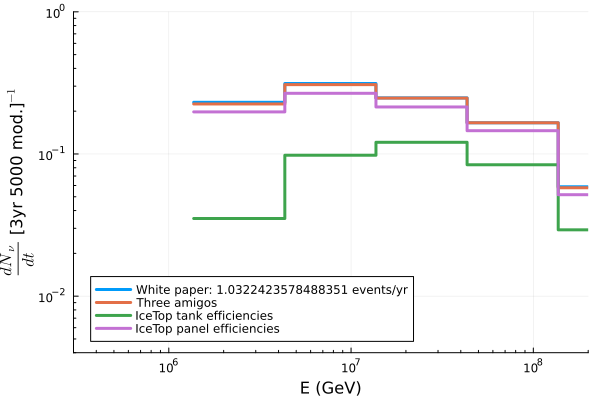

In [19]:
plt = plot(
    xscale=:log,
    yscale=:log,
    xlabel="E (GeV)",
    xminorticks=true,
    yminorticks=true,
    ylabel="\$ \\frac{dN_{\\nu}}{dt}\$ [3yr 5000 mod.]\$^{-1}\$",
    xlimits=(3e5, 2e8),
    ylimits=(4e-3, 1e0),
    legend=:bottomleft,
    size=(600, 400)   
)

nmodules = 400
edges = 10 .^ (14:0.5:18)
cents = (edges[1:end-1] .+ edges[2:end]) / 2

label = "White paper: $(events_per_year_wp) events/yr"
hist_wp = fit(Histogram, triggered_events_white_paper["initial_state"]["energy"], Weights(rates_white_paper), edges)
plot!(
    plt,
    cents / units.GeV,
    hist_wp.weights .* units.second * 3*10^7.5 .* (5_000 / nmodules),
    linetype=:stepmid,
    label=label,
    lw=3
    )

label = "Three amigos"
hist_three = fit(Histogram, triggered_events_three_amigos["initial_state"]["energy"], Weights(rates_three_amigos), edges)
plot!(
    plt,
    cents / units.GeV,
    hist_three.weights .* units.second * 3*10^7.5 .* (5_000 / nmodules),
    linetype=:stepmid,
    label=label,
    lw=3
    )

label = "IceTop tank efficiencies"
hist_it = fit(Histogram, triggered_events_icetop_tanks["initial_state"]["energy"], Weights(rates_icetop_tanks), edges)
plot!(
    plt,
    cents / units.GeV,
    hist_it.weights .* units.second * 3*10^7.5 .* (5_000 / nmodules),
    linetype=:stepmid,
    label=label,
    lw=3
    )

label = "IceTop panel efficiencies"
hist_it = fit(Histogram, triggered_events_icetop_panels["initial_state"]["energy"], Weights(rates_icetop_panels), edges)
plot!(
    plt,
    cents / units.GeV,
    hist_it.weights .* units.second * 3*10^7.5 .* (5_000 / nmodules),
    linetype=:stepmid,
    label=label,
    lw=3
    )

display(plt)